In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import cv2

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import xml.etree.ElementTree as ET

In [5]:
df_train = pd.DataFrame()
for filename in os.listdir('/content/drive/My Drive/Calisma_ortami/Datasets/Chess_Detection/data/'):
    if filename.split('.')[1] == 'xml':
        converted_data_train = {
        'image_name': [],
        'x_min': [],
        'y_min': [],
        'x_max': [],
        'y_max': [],
        'class_name': [],}

        tree = ET.parse("/content/drive/My Drive/Calisma_ortami/Datasets/Chess_Detection/data/" +filename)
        root = tree.getroot()
        imname = root.find('filename').text
        converted_data_train['image_name'] ="/content/drive/My Drive/Calisma_ortami/Datasets/Chess_Detection/data/" + imname

        for boxes in root.iter('object'):
            ymin, xmin, ymax, xmax = None, None, None, None
            objname = boxes.find("name").text
            converted_data_train['class_name'] = objname
            for box in boxes.findall("bndbox"):
                ymin = int(box.find("ymin").text)
                xmin = int(box.find("xmin").text)
                ymax = int(box.find("ymax").text)
                xmax = int(box.find("xmax").text)
                converted_data_train['x_min'] = int(xmin)
                converted_data_train['y_min'] = int(ymin)
                converted_data_train['x_max'] = int(xmax)
                converted_data_train['y_max'] = int(ymax)
            df_train = df_train.append(converted_data_train, ignore_index=True)
          

        

In [6]:
def show_image_with_boxes(df):
  filepath = df.sample()['image_name'].values[0]


  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(0, 255, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [ ]:
df_train

In [8]:
df_train = df_train[['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']]

In [9]:
df_train = df_train.astype({"x_min": int, "y_min": int, "x_max": int, "y_max": int})

In [ ]:
show_image_with_boxes(df_train)

In [11]:
df_train.to_csv('annotations.csv', index=False, header=None)

In [ ]:
df_train.class_name.unique()

In [13]:
classes = ['black-pawn', 'white-pawn', 'black-bishop', 'black-rook',
       'black-knight', 'white-bishop', 'white-queen', 'black-king',
       'white-knight', 'white-king', 'black-queen', 'white-rook']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [ ]:
!head classes.csv

In [ ]:
!head annotations.csv

In [16]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [17]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [ ]:
%cd keras-retinanet/

In [ ]:
!keras_retinanet/bin/train.py  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 2 \
  --steps 20 \
  --epochs 50 \
  csv annotations.csv classes.csv

In [ ]:
!ls snapshots

In [22]:
model = models.load_model("./snapshots/resnet50_csv_25.h5", backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

In [23]:
def show_image_with_predictions(df, threshold=0.6):

  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)
  im = im[:,:,:3]
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  imp = preprocess_image(im)
  imp, scale = resize_image(im)
  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )
  boxes /= scale
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < threshold:
      break
    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)
    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 2
    color = (255, 0, 0) 
    thickness = 2 
    org = (box[0]-25,box[1]-25)
    im = cv2.putText(im, caption, org, font,  fontScale, color, thickness, cv2.LINE_AA) 
    #draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]

filepath: /content/drive/My Drive/Calisma_ortami/Datasets/Chess_Detection/data/IMG_2068.JPG
im.shape: (2248, 4000, 3)
[601, 1318, 1116, 1670]
[1203, 760, 1594, 1172]
[1140, 155, 1582, 738]
[1679, 1251, 2049, 1684]
[2169, 1790, 2554, 2135]
[2536, 95, 2988, 763]
[2569, 796, 2958, 1212]
[3030, 1159, 3677, 1597]


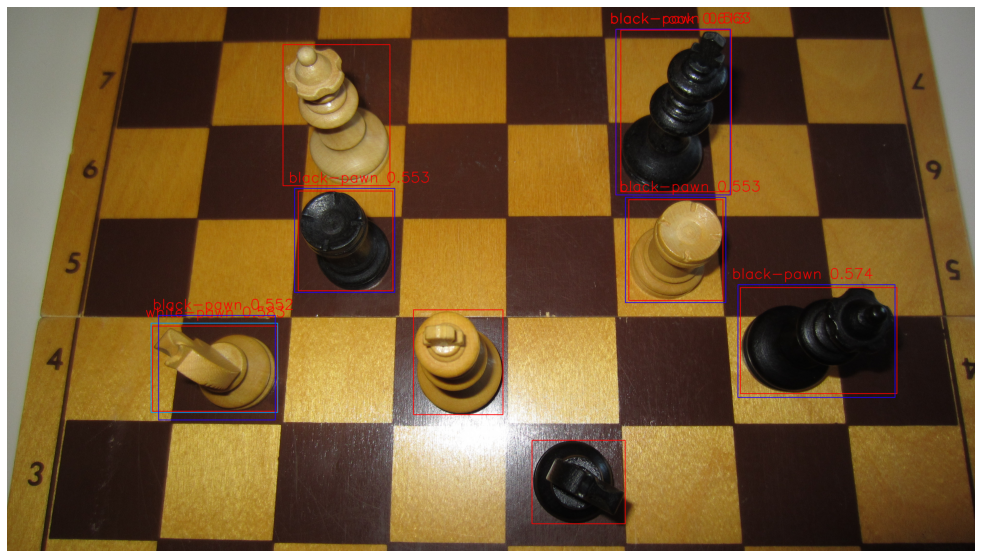

In [44]:
show_image_with_predictions(df_train, threshold=0.5)